In [2]:
from transformers import pipeline
import pandas as pd

In [ ]:
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
df = pd.read_csv("data/cleaned_reviews.csv")
df = df[df["review"].str.strip().astype(bool)]  # remove empty

sentiments = classifier(df["review"].tolist(), truncation=True)
df["sentiment"] = [s["label"].lower() for s in sentiments]
df["sentiment_score"] = [s["score"] for s in sentiments]

df.to_csv("data/sentiment_reviews.csv", index=False)

In [5]:
df = pd.read_csv('data/sentiment_reviews.csv')
df.head()

,review,rating,date,bank,source,sentiment,sentiment_score
0,what is this app problem???,1,2025-06-05,CBE,Google Play,negative,0.999623
1,not functional,1,2025-06-05,CBE,Google Play,negative,0.999779
2,everytime you uninstall the app you have to re...,1,2025-06-04,CBE,Google Play,negative,0.990516
3,yetemeta,1,2025-06-03,CBE,Google Play,positive,0.655366
4,it is not safety,1,2025-06-03,CBE,Google Play,negative,0.999787


In [7]:
agg = df.groupby(["bank", "rating"])["sentiment_score"].mean().reset_index()
agg.to_csv("data/mean_sentiment_by_rating.csv", index=False)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

In [21]:
nlp = spacy.load("en_core_web_sm")
df = pd.read_csv("data/sentiment_reviews.csv")

In [22]:
# Basic preprocessing
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return " ".join(tokens)

df["clean_review"] = df["review"].astype(str).apply(preprocess)

In [24]:
# TF-IDF to extract keywords
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100)
X = vectorizer.fit_transform(df["clean_review"])
keywords = vectorizer.get_feature_names_out()

In [25]:
# Manual rule-based theme mapping
theme_map = {
    "access": ["login", "password", "reset", "fail", "unable"],
    "performance": ["slow", "crash", "freeze", "delay"],
    "UX": ["design", "interface", "navigation", "easy", "layout"],
    "features": ["transfer", "top up", "bill", "pay", "notification"],
    "support": ["help", "customer", "contact", "agent"]
}

def map_theme(text):
    matched = []
    for theme, keys in theme_map.items():
        if any(k in text for k in keys):
            matched.append(theme)
    return ", ".join(set(matched)) if matched else "other"

df["themes"] = df["clean_review"].apply(map_theme)

In [26]:
df.head()

,review,rating,date,bank,source,sentiment,sentiment_score,clean_review,themes
0,what is this app problem???,1,2025-06-05,CBE,Google Play,negative,0.999623,app problem,other
1,not functional,1,2025-06-05,CBE,Google Play,negative,0.999779,functional,other
2,everytime you uninstall the app you have to re...,1,2025-06-04,CBE,Google Play,negative,0.990516,everytime uninstall app reach physically oldy ...,other
3,yetemeta,1,2025-06-03,CBE,Google Play,positive,0.655366,yetemeta,other
4,it is not safety,1,2025-06-03,CBE,Google Play,negative,0.999787,safety,other


In [28]:
df.to_csv("data/thematic_reviews.csv", index=False)

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

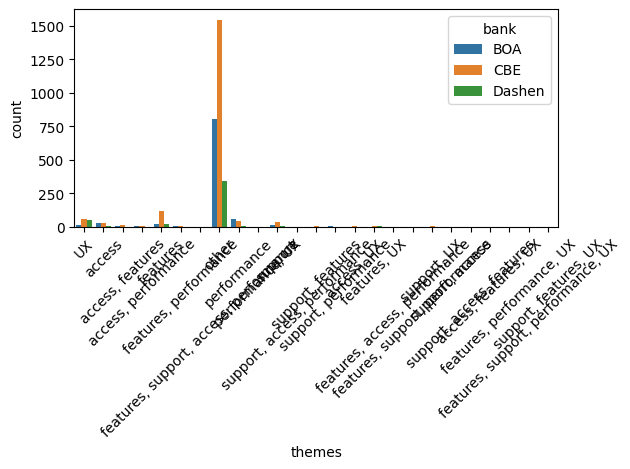

In [31]:
theme_counts = df.groupby(["bank", "themes"]).size().reset_index(name="count")
sns.barplot(data=theme_counts, x="themes", y="count", hue="bank")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("data/theme_distribution.png")
plt.show()